# Thorlabs TCube controller

Gathering all imports necessary 

In [17]:
%matplotlib widget
import time
import clr # need to import pythonnet (can be done from pip)
from matplotlib import pyplot as plt
import datetime as dt

# to access dll namespaces from Thorlabs, we need to first add the references
clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.DeviceManagerCLI.dll")
clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.GenericMotorCLI.dll")
clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.TCube.DCServoCLI.dll")

# import methods/objects from Thorlabs namespaces
from Thorlabs.MotionControl.DeviceManagerCLI import *
from Thorlabs.MotionControl.GenericMotorCLI import *
from Thorlabs.MotionControl.GenericMotorCLI.ControlParameters import JogParametersBase
from Thorlabs.MotionControl.TCube.DCServoCLI import *
from System import Decimal # Kinesis libraries use Decimal type for move parameters and stage settings

## User Input

In [18]:
user_position = float(input("Please specify position in mm: "))
animation_active = True

## Main body of the program

In [19]:
def main():
    
    serial_num = str('83835052') # use S/N of T Cube controller
    
    DeviceManagerCLI.BuildDeviceList() # load available devices into memory
    controller = TCubeDCServo.CreateTCubeDCServo(serial_num) # create controller variable
    
    if not controller == None: # check if connection worked
        controller.Connect(serial_num)
        
        if not controller.IsSettingsInitialized(): # wait for connection and initialization
            controller.WaitForSettingsInitialized(3000) # in units of ms
        
        controller.StartPolling(50) # instruct controller to send updates about position and motor status to PC with update rate of 50ms
        time.sleep(.1) # give controller time to update, good habits to set as twice the duration of polling rate
        controller.EnableDevice()
        time.sleep(.1)
        
        # load parameters for translation stage into the TCube
        config = controller.LoadMotorConfiguration(serial_num, DeviceConfiguration.DeviceSettingsUseOptionType.UseFileSettings)
        config.DeviceSettingsName = str('MTS50-Z8') # use part number of this stage
        config.UpdateCurrentConfiguration()
        controller.SetSettings(controller.MotorDeviceSettings, True, False)
        info = controller.GetDeviceInfo()
        
        print(f"Controller {serial_num} = {info.Name}")

        print('Homing Motor')
        controller.Home(60000) # if command does not complete by the end of this time, it will throw an error
        
        # to change the jog params of the translation stage, first import them with the GetJogParams method and then modify
        jog_params = controller.GetJogParams()
        jog_params.StepSize = Decimal(1) # units in mm
        jog_params.MaxVelocity = Decimal(2) # units in mm/s
        jog_params.JogMode = JogParametersBase.JogModes.SingleStep
        
        # send updated jog params back to the controller
        controller.SetJogParams(jog_params)
        
        print('Moving Motor')
        controller.MoveTo(Decimal(user_position), 0) # immediately continue
        time.sleep(.25)

        fig, ax = plt.subplots()
        xs = []
        ys = []

        while controller.IsDeviceBusy:
            print(f"{controller.Position} mm")
            time.sleep(.1)
            pos = controller.Position.ToString()

            xs.append(dt.datetime.now().strftime('%H:%M:%S.%f'))
            ys.append(pos)
            print(ys)
            
            ln, = ax.plot(xs, ys)
            plt.ion();plt.show()

            plt.xticks(rotation=45, ha='right')
            plt.subplots_adjust(bottom=.3)
            plt.title(f"{controller.GetDeviceInfo().Name} Position over Time")
            
        
        # want the controller to move first to user specified position and then 
        # depending on the input of the zurich to move towards or away from the assumed position.

        controller.StopPolling()
        controller.Disconnect(False)

Controller 83835052 = TDC001
Homing Motor
Moving Motor
0.04225 mm
['0.0859']


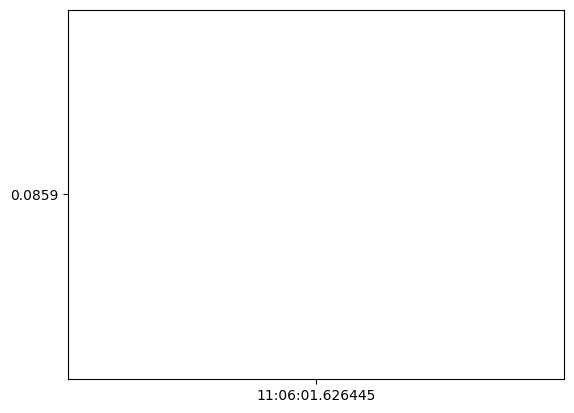

0.14678 mm
['0.0859', '0.2226']


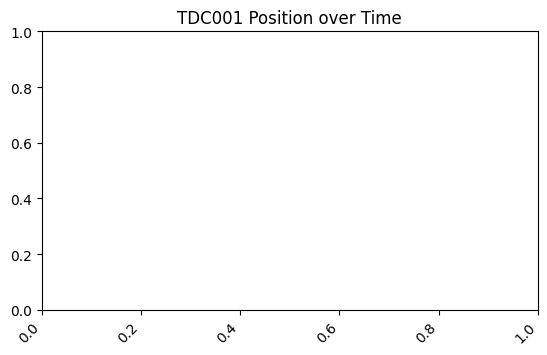

0.4783 mm
['0.0859', '0.2226', '0.6811']


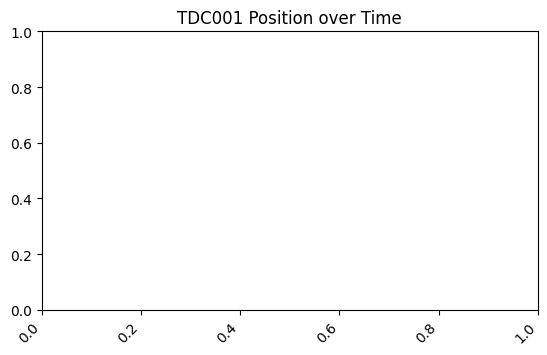

1.09524 mm
['0.0859', '0.2226', '0.6811', '1.19372']


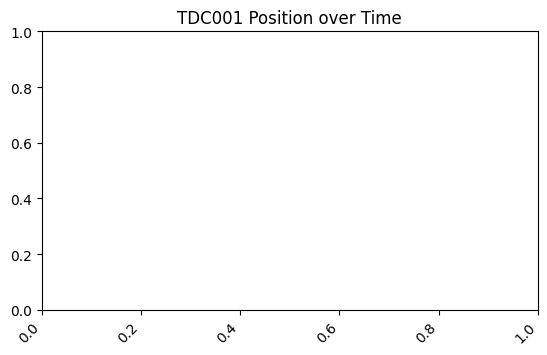

1.85166 mm
['0.0859', '0.2226', '0.6811', '1.19372', '2.06135']


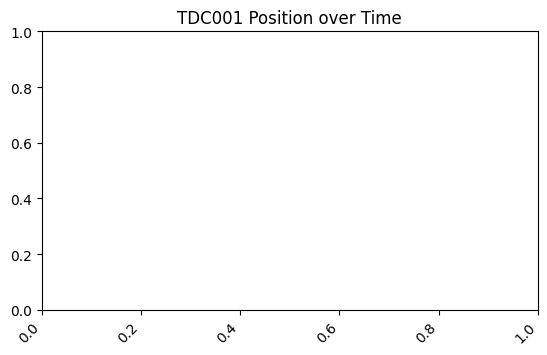

2.52844 mm
['0.0859', '0.2226', '0.6811', '1.19372', '2.06135', '2.69215']


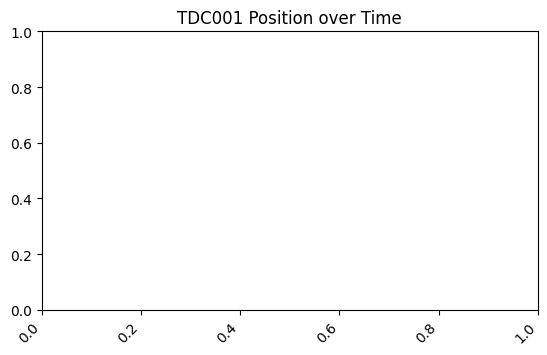

2.91773 mm
['0.0859', '0.2226', '0.6811', '1.19372', '2.06135', '2.69215', '2.969']


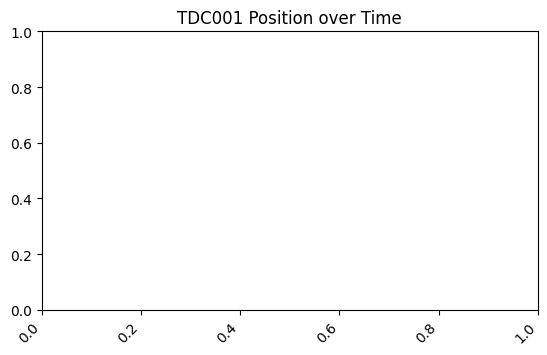

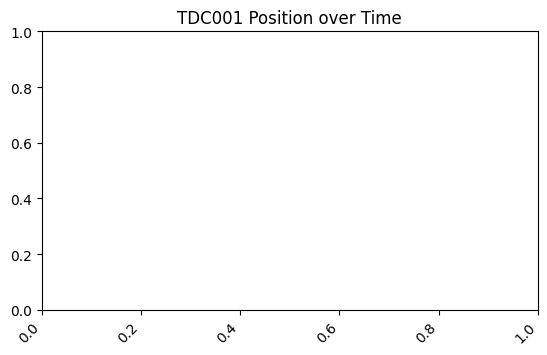

In [20]:
if __name__ == "__main__":
    main()